# Model comparison with pymc: application to ARX models

[pymc notebook on model comparison](https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/model_comparison.html)

sinon plus simple

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import arviz as az
import pymc as pm

In [2]:
df = pd.read_csv('data/armaxdata.csv')
df.head()

,datetime,Ti,Te,P
0,2023-04-07 20:00:00,21.017708,8.008333,1127.547691
1,2023-04-07 22:00:00,21.022083,6.254167,1095.384059
2,2023-04-08 00:00:00,21.023750,5.258333,1073.813890
3,2023-04-08 02:00:00,21.010625,3.381250,1101.343786
4,2023-04-08 04:00:00,21.009167,3.118750,1131.881637


Text(0.5, 0, 'Ti-Te')

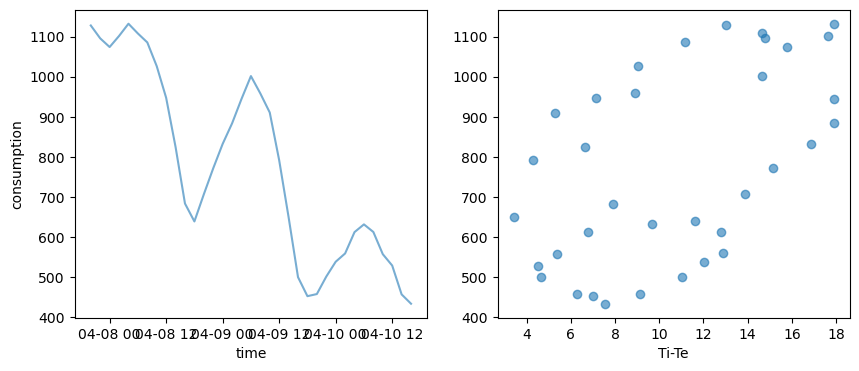

In [3]:
# A plot of the dependent variable vs. each of the explanatory variables
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
#axes[0].plot(df['datetime'], df['Ti'], alpha=0.6)
#axes[0].plot(df['datetime'], df['Te'], alpha=0.6)
axes[0].plot(pd.to_datetime(df['datetime']), df['P'], alpha=0.6)
axes[1].scatter(df['Ti']-df['Te'], df['P'], alpha=0.6)
axes[0].set_ylabel("consumption")
axes[0].set_xlabel("time")
axes[1].set_xlabel("Ti-Te")

In [4]:
df_shift = df.shift([0,1,2], fill_value=0)
df_shift.head()

,datetime_0,Ti_0,Te_0,P_0,datetime_1,Ti_1,Te_1,P_1,datetime_2,Ti_2,Te_2,P_2
0,2023-04-07 20:00:00,21.017708,8.008333,1127.547691,0,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000
1,2023-04-07 22:00:00,21.022083,6.254167,1095.384059,2023-04-07 20:00:00,21.017708,8.008333,1127.547691,0,0.000000,0.000000,0.000000
2,2023-04-08 00:00:00,21.023750,5.258333,1073.813890,2023-04-07 22:00:00,21.022083,6.254167,1095.384059,2023-04-07 20:00:00,21.017708,8.008333,1127.547691
3,2023-04-08 02:00:00,21.010625,3.381250,1101.343786,2023-04-08 00:00:00,21.023750,5.258333,1073.813890,2023-04-07 22:00:00,21.022083,6.254167,1095.384059
4,2023-04-08 04:00:00,21.009167,3.118750,1131.881637,2023-04-08 02:00:00,21.010625,3.381250,1101.343786,2023-04-08 00:00:00,21.023750,5.258333,1073.813890


In [5]:
df_shift = df_shift.iloc[2:].reset_index()
df_shift.head()

,index,datetime_0,Ti_0,Te_0,P_0,datetime_1,Ti_1,Te_1,P_1,datetime_2,Ti_2,Te_2,P_2
0,2,2023-04-08 00:00:00,21.023750,5.258333,1073.813890,2023-04-07 22:00:00,21.022083,6.254167,1095.384059,2023-04-07 20:00:00,21.017708,8.008333,1127.547691
1,3,2023-04-08 02:00:00,21.010625,3.381250,1101.343786,2023-04-08 00:00:00,21.023750,5.258333,1073.813890,2023-04-07 22:00:00,21.022083,6.254167,1095.384059
2,4,2023-04-08 04:00:00,21.009167,3.118750,1131.881637,2023-04-08 02:00:00,21.010625,3.381250,1101.343786,2023-04-08 00:00:00,21.023750,5.258333,1073.813890
3,5,2023-04-08 06:00:00,21.014792,6.356250,1107.555516,2023-04-08 04:00:00,21.009167,3.118750,1131.881637,2023-04-08 02:00:00,21.010625,3.381250,1101.343786
4,6,2023-04-08 08:00:00,21.013750,9.864583,1085.307234,2023-04-08 06:00:00,21.014792,6.356250,1107.555516,2023-04-08 04:00:00,21.009167,3.118750,1131.881637


## Zero order model
$$ P_t = \theta (T_i-T_e)_t$$
$$ y_t \sim N(P_t, \sigma)$$
$$ \theta \sim N(50,10) $$
$$ \sigma \sim \mathrm{HalfNormal}(100) $$

In [6]:
TiTe = df_shift['Ti_0'] - df_shift['Te_0']
Y = df_shift['P_0']

model0 = pm.Model()

with model0:
    # Priors for unknown model parameters
    theta = pm.Normal("theta", mu=50, sigma=10)
    sigma = pm.HalfNormal("sigma", sigma=100)

    # Expected value of outcome
    mu = theta * TiTe

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=Y)

    trace_0 = pm.sample(2000, idata_kwargs={"log_likelihood": True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta, sigma]


C:\ProgramData\Anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 60 seconds.


C:\ProgramData\Anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

We recommend running at least 4 chains for robust computation of convergence diagnostics


In [7]:
az.summary(trace_0)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma,257.320,28.036,204.981,308.905,0.479,0.344,3472.0,2711.0,1.0
theta,62.549,3.672,55.641,69.417,0.063,0.045,3309.0,2858.0,1.0


$$ P_t = \beta_1 P_{t-1} + \theta_0 (T_i-T_e)_t + \theta_1 (T_i-T_e)_{t-1}$$

In [8]:
TiTe_1 = df_shift['Ti_1'] - df_shift['Te_1']
P_1 = df_shift['P_1']

model1 = pm.Model()

with model1:
    # Priors for unknown model parameters
    beta = pm.Normal("beta", mu=0, sigma=1)
    theta = pm.Normal("theta", mu=30, sigma=10, shape=2)
    sigma = pm.HalfNormal("sigma", sigma=100)

    # Expected value of outcome
    mu = beta * P_1 + theta[0] * TiTe + theta[1] * TiTe_1

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=Y)

    trace_1 = pm.sample(2000, idata_kwargs={"log_likelihood": True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, theta, sigma]


C:\ProgramData\Anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 69 seconds.


C:\ProgramData\Anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

We recommend running at least 4 chains for robust computation of convergence diagnostics


In [9]:
az.summary(trace_1)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta,0.764,0.018,0.729,0.797,0.000,0.000,1767.0,1689.0,1.0
sigma,26.464,3.647,20.084,33.128,0.083,0.060,2014.0,1974.0,1.0
theta[0],1.541,2.089,-2.313,5.548,0.050,0.038,1746.0,1834.0,1.0
theta[1],13.883,2.531,9.339,18.922,0.065,0.046,1535.0,1645.0,1.0


$$ P_t = \sum_{i=1}^2 \beta_i P_{t-i} + \sum_{j=0}^2 \theta_j (T_i-T_e)_{t-j} $$

In [10]:
TiTe_2 = df_shift['Ti_2'] - df_shift['Te_2']
P_2 = df_shift['P_2']

model2 = pm.Model()

with model2:
    # Priors for unknown model parameters
    beta = pm.Normal("beta", mu=0, sigma=1, shape=2)
    theta = pm.Normal("theta", mu=30, sigma=10, shape=3)
    sigma = pm.HalfNormal("sigma", sigma=100)

    # Expected value of outcome
    mu = beta[0] * P_1 + beta[1] * P_2 + theta[0] * TiTe + theta[1] * TiTe_1 + theta[2] * TiTe_2

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=Y)

    trace_2 = pm.sample(2000, idata_kwargs={"log_likelihood": True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, theta, sigma]


C:\ProgramData\Anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 123 seconds.


C:\ProgramData\Anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [11]:
model1_loo = az.loo(trace_1)
model1_loo

Computed from 4000 posterior samples and 33 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -156.20     3.54
p_loo        3.76        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       33  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [12]:
df_comp_loo = az.compare({"model0": trace_0, "model1": trace_1, "model2": trace_2}, ic="loo")
df_comp_loo

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
model1,0,-156.196379,3.764941,0.000000,0.837058,3.535720,0.000000,False,log
model2,1,-156.778118,4.501651,0.581739,0.162942,3.240688,1.335494,False,log
model0,2,-233.264786,1.291967,77.068407,0.000000,4.086258,4.741213,False,log


Copied from [PyMC's documentation](https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/model_comparison.html):

* rank, the ranking of the models starting from 0 (best model) to the number of models.
* elpd_loo, the values of LOO (or WAIC). The DataFrame is always sorted from best LOO/WAIC to worst.
* p_loo, the value of the penalization term. We can roughly think of this value as the estimated effective number of parameters (but do not take that too seriously).
* d_loo, the relative difference between the value of LOO/WAIC for the top-ranked model and the value of LOO/WAIC for each model.
* weight, the weights assigned to each model. These weights can be loosely interpreted as the probability of each model being true (among the compared models) given the data.
* se, the standard error for the LOO/WAIC computations. The standard error can be useful to assess the uncertainty of the LOO/WAIC estimates. By default these errors are computed using stacking.
* dse, the standard errors of the difference between two values of LOO/WAIC. The same way that we can compute the standard error for each value of LOO/WAIC, we can compute the standard error of the differences between two values of LOO/WAIC. Notice that both quantities are not necessarily the same, the reason is that the uncertainty about LOO/WAIC is correlated between models. This quantity is always 0 for the top-ranked model.
* warning, If True the computation of LOO/WAIC may not be reliable.
* loo_scale, the scale of the reported values. The default is the log scale as previously mentioned. Other options are deviance – this is the log-score multiplied by -2 (this reverts the order: a lower LOO/WAIC will be better) – and negative-log – this is the log-score multiplied by -1 (as with the deviance scale, a lower value is better)

<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

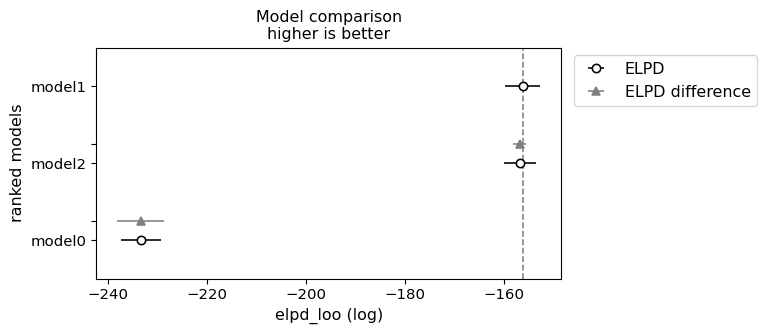

In [13]:
az.plot_compare(df_comp_loo, insample_dev=False)

In [14]:
df_comp_waic = az.compare({"model0": trace_0, "model1": trace_1, "model2": trace_2}, ic="waic")
df_comp_waic

C:\ProgramData\Anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:1632: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
C:\ProgramData\Anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:1632: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


,rank,elpd_waic,p_waic,elpd_diff,weight,se,dse,warning,scale
model1,0,-156.115159,3.683721,0.000000,0.825066,3.511150,0.000000,True,log
model2,1,-156.669296,4.392829,0.554136,0.174934,3.218189,1.324512,True,log
model0,2,-233.256398,1.283580,77.141239,0.000000,4.083453,4.727704,False,log


In [15]:
model1_waic = az.waic(trace_1)
model1_waic

C:\ProgramData\Anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:1632: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 4000 posterior samples and 33 observations log-likelihood matrix.

          Estimate       SE
elpd_waic  -156.12     3.51
p_waic        3.68        -

There has been a warning during the calculation. Please check the results.

model 1 is best, let's see if we can improve it with MA

$$ P_t = \beta_1 P_{t-1} + \theta_0 (T_i-T_e)_t + \theta_1 (T_i-T_e)_{t-1} + \gamma \varepsilon_{t-1} + \varepsilon_t$$

## Enhancing the model: ARMAX

difficult to do in pymc but possible in stan

https://srouchier.github.io/bayesmv/